In [1]:
import pandas as pd
import numpy as np
import dslabs_functions as dslabs
from matplotlib.pyplot import figure, show, subplots, plot, legend, savefig
from matplotlib.axes import Axes
from matplotlib.figure import Figure

Index(['Total'], dtype='object')
Nr. Records =  2976
First timestamp 2023-10-01 00:00:00
Last timestamp 2023-10-31 23:45:00


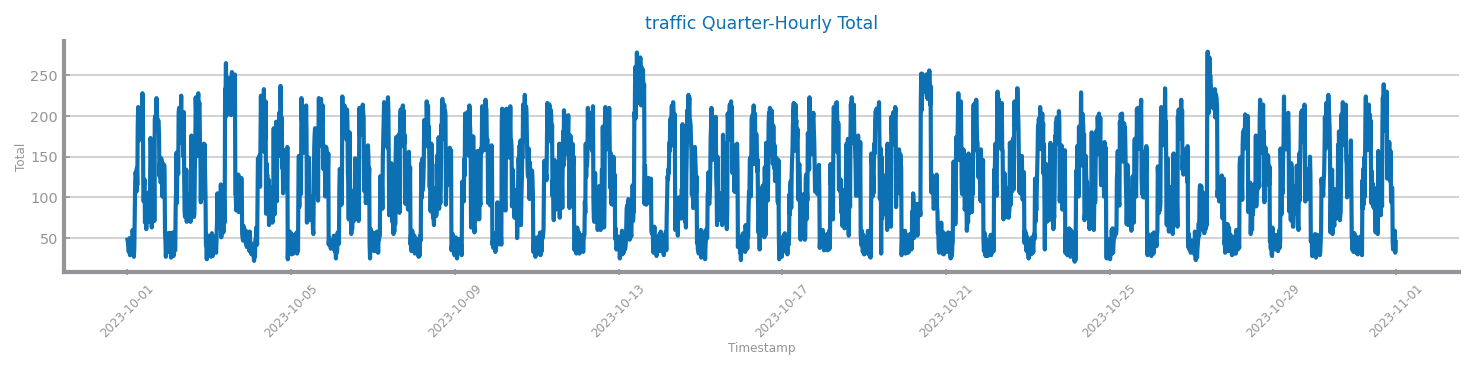

In [2]:
### plotting UNIVARIATE Time Series
file_tag = "traffic"
target = "Total"
index="Timestamp"
### ordenar dados no csv ou nao e preciso??? last timestamp esta mal pq dados no csv nao estao ordenados por data
original_data: pd.DataFrame = pd.read_csv(
    "forecast_traffic_single.csv",
    index_col="Timestamp",
    sep=",",
    decimal=".",
    parse_dates=True,
    infer_datetime_format=True,
)

print(original_data.columns)

### Sort 'TimeStamp' Ascending
original_data.sort_index(inplace=True)
#original_data.to_csv("sorted_forecast_traffic.csv")
series: pd.Series = original_data[target]

print("Nr. Records = ", series.shape[0])
print("First timestamp", series.index[0])
print("Last timestamp", series.index[-1])

figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT / 2))
dslabs.plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} Quarter-Hourly {target}",
)
show()

744
-----
186
-----
93
-----
31
-----
6
-----


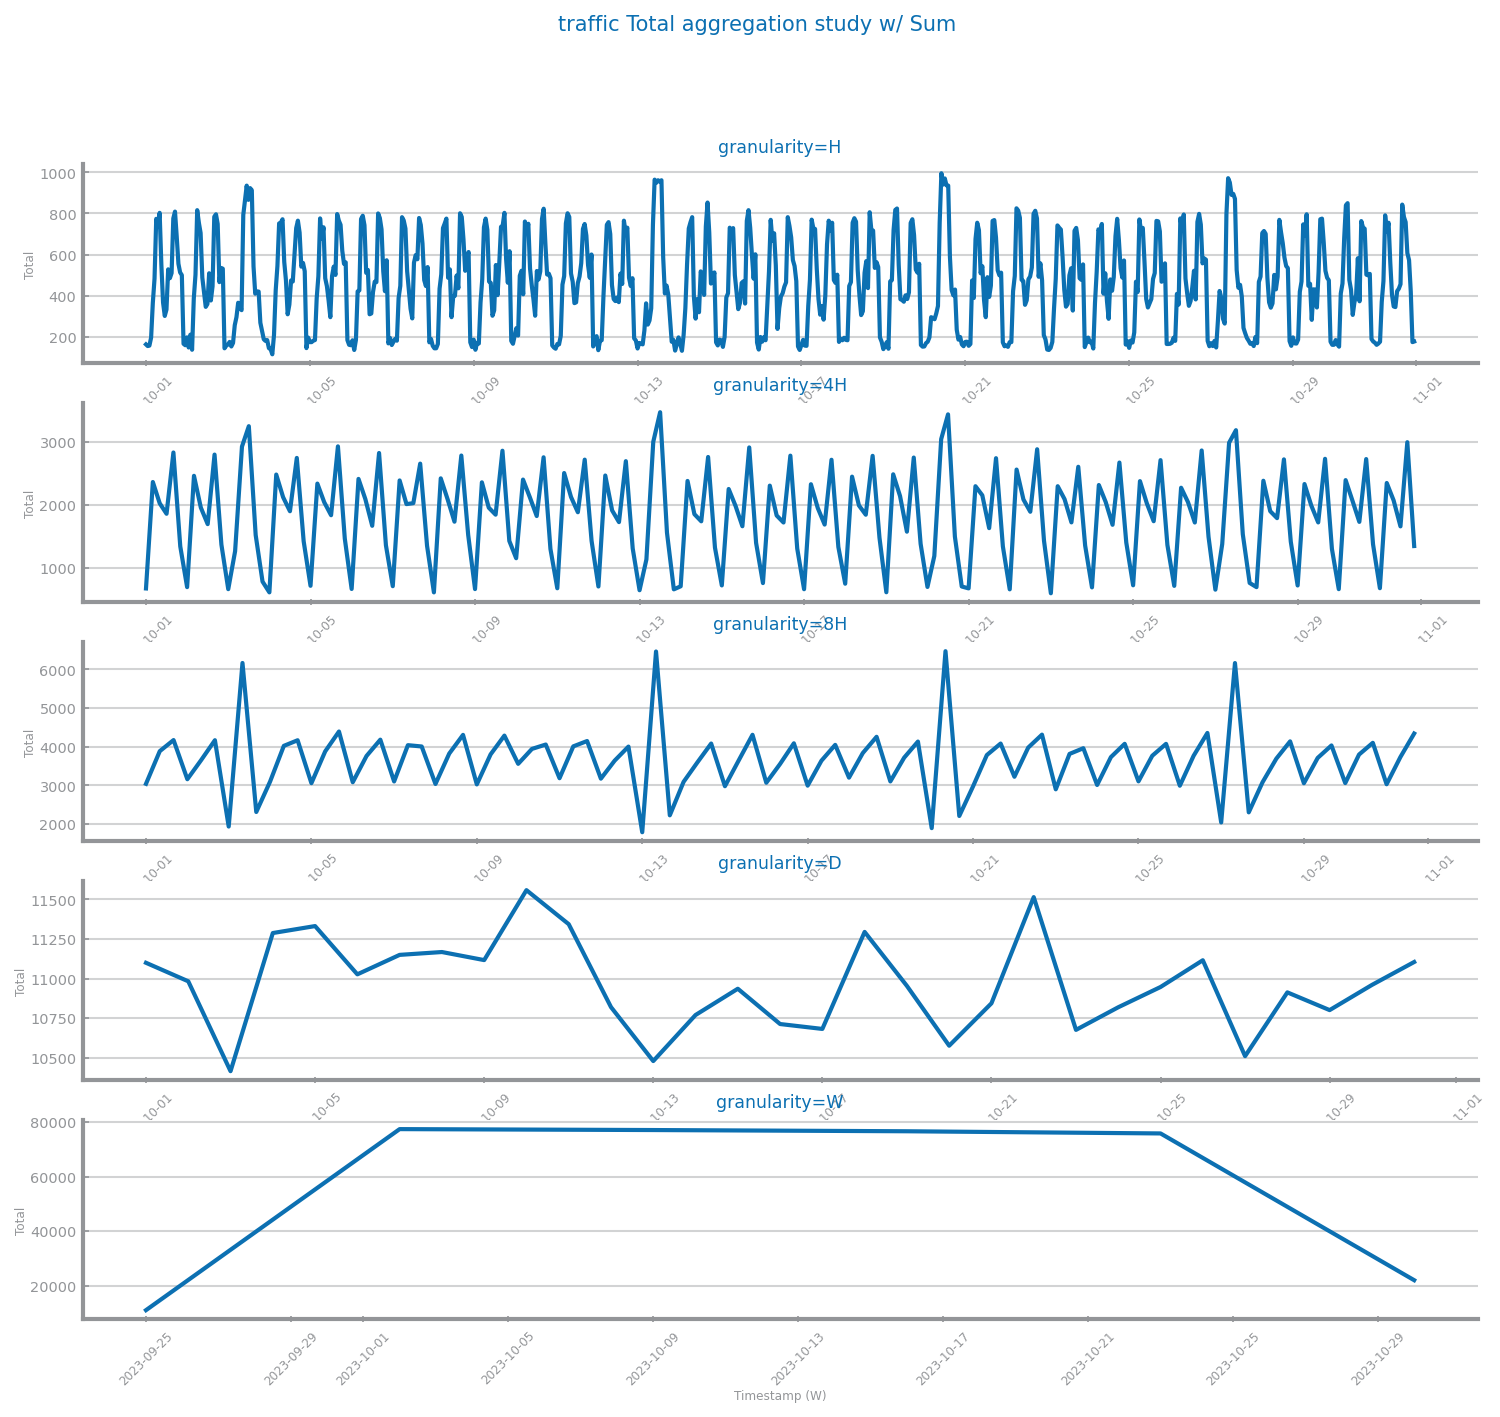

In [25]:
import pandas as pd
from matplotlib.pyplot import subplots, Figure

# Assuming original_data, series, dslabs, file_tag, and target are defined

grans = ["H", "4H", "8H", "D", "W"]
fig, axs = subplots(len(grans), 1, figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT / 2 * len(grans)))
fig.suptitle(f"{file_tag} {target} aggregation study w/ Sum")

for i, gran in enumerate(grans):
    if gran == "4H":
        grouped_sum = []
        indices = []
        for j in range(0, len(original_data), 16):
            sum_value = original_data.iloc[j:j+16]['Total'].sum()
            grouped_sum.append(sum_value)
            indices.append(original_data.index[j])
        ss = pd.Series(grouped_sum, index=indices)
    elif gran == "8H":
        grouped_sum = []
        indices = []
        for j in range(0, len(original_data), 32):
            sum_value = original_data.iloc[j:j+32]['Total'].sum()
            grouped_sum.append(sum_value)
            indices.append(original_data.index[j])
        ss = pd.Series(grouped_sum, index=indices)
    else:
        ss = dslabs.ts_aggregation_by(series, gran, "sum")
    
    print(len(ss))
    print("-----")
    dslabs.plot_line_chart(
        ss.index.to_list(),
        ss.to_list(),
        ax=axs[i],
        xlabel=f"{ss.index.name} ({grans[i]})",
        ylabel=target,
        title=f"granularity={grans[i]}",
    )

show()